# Real-time Taxi Fare Prediction: New York City
The NYC-taxi dataset contains information from 50000 trips completed in the city. The geographical coordinates (latitude and longitude) were captured for pickups and drop-offs as well as the date and time of the pickup. There is also a column for the number of passengers and the correspding charged fare for each of the trips. 
### Let's start by importing the libraries:

In [2]:
import pandas as pd
import os 
import random
import numpy as np 
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import seaborn as sns
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential

Now we can import the dataset as a dataframe with Pandas and see its full description to look for the first inconsistencies:

In [3]:
folder = os.getcwd().replace('\\','/')+'/NYC_taxi'

In [4]:
df = pd.read_csv(folder+'/NYC_taxi.csv', sep=',', parse_dates=['pickup_datetime'])

In [5]:
#general stats
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,11.364171,-72.509756,39.933759,-72.504616,39.926251,1.667840
std,9.685557,10.393860,6.224857,10.407570,6.014737,1.289195
min,-5.000000,-75.423848,-74.006893,-84.654241,-74.006377,0.000000
25%,6.000000,-73.992062,40.734880,-73.991152,40.734371,1.000000
50%,8.500000,-73.981840,40.752678,-73.980082,40.753372,1.000000
75%,12.500000,-73.967148,40.767360,-73.963584,40.768167,2.000000
max,200.000000,40.783472,401.083332,40.851027,43.415190,6.000000


In [6]:
#data types of the different columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   key                50000 non-null  object             
 1   fare_amount        50000 non-null  float64            
 2   pickup_datetime    50000 non-null  datetime64[ns, UTC]
 3   pickup_longitude   50000 non-null  float64            
 4   pickup_latitude    50000 non-null  float64            
 5   dropoff_longitude  50000 non-null  float64            
 6   dropoff_latitude   50000 non-null  float64            
 7   passenger_count    50000 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1), object(1)
memory usage: 3.1+ MB


In [7]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1


The key column seems to be redundant so we can safely remove it. We can further look for some empty values to remove in case the data is not yet clean:

In [8]:
#remove key column as it appears to be redundant
df = df.drop(['key'], axis=1)

In [9]:
df.isnull().sum() #data seems to be clean *smiley*

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [10]:
df.dropna()
df.describe() 

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,11.364171,-72.509756,39.933759,-72.504616,39.926251,1.667840
std,9.685557,10.393860,6.224857,10.407570,6.014737,1.289195
min,-5.000000,-75.423848,-74.006893,-84.654241,-74.006377,0.000000
25%,6.000000,-73.992062,40.734880,-73.991152,40.734371,1.000000
50%,8.500000,-73.981840,40.752678,-73.980082,40.753372,1.000000
75%,12.500000,-73.967148,40.767360,-73.963584,40.768167,2.000000
max,200.000000,40.783472,401.083332,40.851027,43.415190,6.000000


In the following we plot some histograms of the fare_amount column, longitudes and latitudes. It is worth mentioning that fares should make sense i.e. values must be greater than zero and not really big like, say 100.

From geographical conventions latitude values range between $0$ and $\pi$ $(-90°, 90°)$ while longitude ranges from $0$ to $2\pi$ $(-180°, 180°)$.

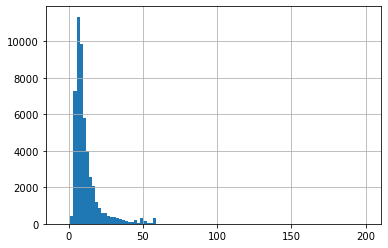

In [16]:
df['fare_amount'].hist(bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002800910BA08>,
      dtype=object)

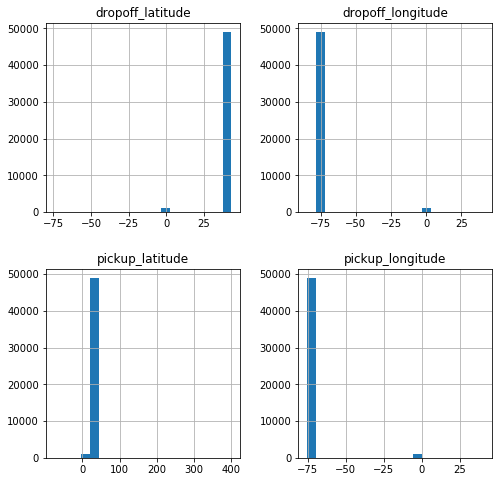

In [25]:
#plt.figure(figsize=(10,10))
df[['pickup_latitude', 'pickup_longitude','dropoff_latitude', 'dropoff_longitude']].hist(figsize=(8,8),bins=20)
#df['pickup_longitude'].hist()
#df['pickup_latitude'].hist()

Let's now proceede to clean the dataset following the already mention conventions. In the case of the passenger_count column there are some zero values. Since that doesn't typically make sense and we don't want to remove those values altogether, it is a better practice to replace them with the mode which in this case is 1 (from the above describe column where the 50% quantile is shown).

In [42]:
df = df[(df['fare_amount'] >=0) & (df['fare_amount'] <= 100)] # 200 is way over the average so maybe is an error (or ripoff) 
df = df[(df['pickup_longitude'] >=-180) & (df['pickup_longitude'] <= 180)]
df = df[(df['dropoff_longitude'] >=-180) & (df['dropoff_longitude'] <= 180)]
df = df[(df['pickup_latitude'] >=-90) & (df['pickup_latitude'] <= 90)]
df = df[(df['dropoff_latitude'] >=-90) & (df['dropoff_latitude'] <= 90)]

In [39]:
#let's replace zeros in the passenger_count column with the mode
df.loc[df['passenger_count']==0, 'passenger_count'] = 1

To have a grasp at the feature columns we can compute the correlation matrix to see what it can tell about the corelations between the features and the target variable (fare_amount):

In [45]:
corr = df.corr()
corr.fare_amount 

fare_amount          1.000000
pickup_longitude     0.004889
pickup_latitude     -0.005746
dropoff_longitude    0.003393
dropoff_latitude    -0.004787
passenger_count      0.017215
Name: fare_amount, dtype: float64

That doesn't make much sense. It looks like we need a more physically relevant variable: the geographical distance.
The geographical distance between two points in the earth globe can be given by the following formula:

\begin{equation}
D = R \sqrt{(\Delta\phi)^2 + (\cos(\bar{\phi})\,\Delta\lambda)^2}
\end{equation}

Where $R\approx 6371$ Kms is the earth radius in Kilometers, $\phi, \lambda$ are the latitude and longitude, respectively and $\bar{\phi}$ is the mean latitude give by:

\begin{equation}
\bar{\phi} = \frac{\phi_{pickup}+\phi_{dropoff}}{2}
\end{equation}

In [46]:
# mean latittude calculation:
phi_mean = np.radians((df.pickup_latitude+df.dropoff_latitude)/2)

In [47]:
#differences in latitudes and longitudes:
dphi = np.radians(df.pickup_latitude-df.dropoff_latitude)
dlambda = np.radians(df.pickup_longitude-df.dropoff_longitude)

In [48]:
# calculate trip (geographical) distance:
R =  6371 #radius of the earth in kilometers
distance = R*np.sqrt(dphi**2 + (np.cos(phi_mean)*dlambda)**2)

In [49]:
# now we set the calculated distance as a new column in the dataframe:
df['distance']=distance

Let's look at the histogram to seek for extreme values that can be removed. Values above 100 for a city of roughly 20 kms of extension can be considered out of the range:

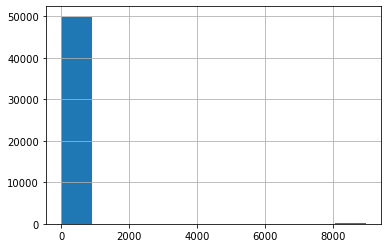

In [58]:
df.distance.hist()

In [68]:
df.distance = df[df.distance < 100]

Now we can also split the values in the pickup_datetime column to have individual values for year, month, day, weekday and hour. To further check the influence of the feature values over the fares we display the correlations. A Scatter plot of the distance vs fare_amount is added to assert whether a linear regression is justified for this model.

In [69]:
import datetime as dt
df['year'] = df['pickup_datetime'].dt.year
df['month'] = df['pickup_datetime'].dt.month
df['day'] = df['pickup_datetime'].dt.day
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek
df['hour'] = df['pickup_datetime'].dt.hour
df = df.drop(['pickup_datetime'], axis=1)

In [70]:
corr2 = df.corr()
corr2 

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,day_of_week,hour
fare_amount,1.000000,0.004889,-0.005746,0.003393,-0.004787,0.017215,0.123476,0.027958,-0.000168,-0.000588,-0.021957
pickup_longitude,0.004889,1.000000,-0.984118,0.956571,-0.947354,-0.005473,-0.001427,0.000458,0.005999,-0.003285,0.005176
pickup_latitude,-0.005746,-0.984118,1.000000,-0.943690,0.961340,0.003853,-0.000768,0.000444,-0.008876,0.001965,-0.004560
dropoff_longitude,0.003393,0.956571,-0.943690,1.000000,-0.982087,-0.004731,-0.000489,0.001379,0.005211,-0.002502,0.005770
dropoff_latitude,-0.004787,-0.947354,0.961340,-0.982087,1.000000,0.002768,-0.001661,-0.000394,-0.008003,0.001677,-0.004775
passenger_count,0.017215,-0.005473,0.003853,-0.004731,0.002768,1.000000,0.006035,0.008499,0.006844,0.038714,0.011377
year,0.123476,-0.001427,-0.000768,-0.000489,-0.001661,0.006035,1.000000,-0.115664,-0.011309,0.006952,0.004429
month,0.027958,0.000458,0.000444,0.001379,-0.000394,0.008499,-0.115664,1.000000,-0.017098,-0.009955,-0.001996
day,-0.000168,0.005999,-0.008876,0.005211,-0.008003,0.006844,-0.011309,-0.017098,1.000000,0.008502,-0.008180
day_of_week,-0.000588,-0.003285,0.001965,-0.002502,0.001677,0.038714,0.006952,-0.009955,0.008502,1.000000,-0.091151


In [71]:
corr2['fare_amount']

fare_amount          1.000000
pickup_longitude     0.004889
pickup_latitude     -0.005746
dropoff_longitude    0.003393
dropoff_latitude    -0.004787
passenger_count      0.017215
year                 0.123476
month                0.027958
day                 -0.000168
day_of_week         -0.000588
hour                -0.021957
Name: fare_amount, dtype: float64

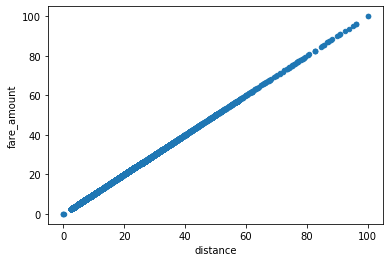

In [72]:
df.plot.scatter('distance','fare_amount')

In [73]:
df = df.dropna()

As expected, the distance and the fares are directly correlated and the linear relation is evident. It also seems that the year has a small influence on the price which might be due to the typical legal annual increase. The next lines are finally dedicated to the modelling.

## Model Selection
As seen from the last part, the most appropriate model to choose is linear regression. Based upon what has been learned so far, we can select the three most known examples from scikit-Learn: Linear Regression, Ridge and Lasso and see if there are comparable differences. At the end, neural network is implemented consisting of Input, Output layers and four fully connected hidden layers with mean-squared-error as the preferred loss function and Adam as optimizer: 

In [74]:
X = df.loc[:, df.columns != 'fare_amount'].astype('float32')
y = df['fare_amount'].astype('float32')

In [75]:
from sklearn.model_selection import train_test_split

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [77]:
X_train.values

array([[  0.      ,   0.      ,   0.      , ...,  28.      ,   2.      ,
          2.      ],
       [-74.00505 ,  40.740807, -73.98663 , ...,   5.      ,   1.      ,
         14.      ],
       [-73.99864 ,  40.764286, -73.99773 , ...,  15.      ,   0.      ,
          2.      ],
       ...,
       [-74.00944 ,  40.710587, -74.0148  , ...,  31.      ,   5.      ,
         15.      ],
       [-73.95288 ,  40.783466, -73.9579  , ...,   6.      ,   3.      ,
         16.      ],
       [-73.968475,  40.799812, -73.98384 , ...,   9.      ,   5.      ,
         13.      ]], dtype=float32)

In [78]:
lr = LinearRegression()
rg = Ridge()
ls = Lasso()

In [79]:
lr.fit(X_train, y_train)
rg.fit(X_train, y_train)
ls.fit(X_train, y_train)

Lasso()

In [80]:
print('Scores for:\n\nLinear Regression || Ridge Regression || Lasso Regression \n\n {:0.2f} \t\t\t {:0.2f} \t\t\t {:0.2f}  '.format(lr.score(X_test, y_test), rg.score(X_test, y_test), ls.score(X_test, y_test)))

Scores for:

Linear Regression || Ridge Regression || Lasso Regression 

 1.00 			 1.00 			 1.00  


In [81]:
model = Sequential()
model.add(Input(shape=(X_train.shape[1])))
model.add(Dense(128, activation='relu')) 
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam', metrics=['mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1536      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 12,145
Trainable params: 12,145
Non-trainable params: 0
_________________________________________________________________


In [82]:
history = model.fit(X_train, y_train, epochs=5, batch_size = 32)

Train on 39896 samples
Epoch 1/5
39896/39896 [==============================] - 10s 263us/sample - loss: 55.2018 - mse: 55.2016
Epoch 2/5
39896/39896 [==============================] - 8s 188us/sample - loss: 0.5010 - mse: 0.5010
Epoch 3/5
39896/39896 [==============================] - 8s 189us/sample - loss: 1.0563 - mse: 1.0563
Epoch 4/5
39896/39896 [==============================] - 8s 190us/sample - loss: 0.8774 - mse: 0.8774
Epoch 5/5
39896/39896 [==============================] - 8s 199us/sample - loss: 0.7239 - mse: 0.7239


In [83]:
mse,_ = model.evaluate(X_test, y_test)

9975/9975 [==============================] - 2s 161us/sample - loss: 0.2704 - mse: 0.2704


## Model predictions 
It is evident that the model behaves well with a linear fit, so there was no real need for a regularization in any form. The neural network also gives very good results in noth the training and test datasets. 
Now it's time for some predictions, for that purpose a dictionary with coordinatized addresses in NYC is stored and a function to calculate the predicted fares is given. The whole details of the trip are displayed along with the prediction for each selected case concluding the development of the model.

In [84]:
landmarks = {'JFK Airport': (-73.78,40.643),
             'Laguardia Airport': (-73.87, 40.77),
             'Midtown': (-73.98, 40.76),
             'Lower Manhattan': (-74.00, 40.72),
             'Upper Manhattan': (-73.94, 40.82),
             'Brooklyn': (-73.95, 40.66),
             'Jamaica Estates': (-73.78, 40.72),
             'St. John’s University': (-73.79, 40.72),
             'Empire State Building': (-73.98, 40.75),
             'Riverdale': (-74.30, 40.99)
            }    

In [85]:
def trip_calculator(start, end, passengers):
    
    pickup_longitude = landmarks[start][0]
    pickup_latitude = landmarks[start][1]
    dropoff_longitude = landmarks[end][0]
    dropoff_latitude = landmarks[end][1]
    
    phi_mean = np.radians((pickup_latitude+dropoff_latitude)/2)
    dphi = np.radians(pickup_latitude-dropoff_latitude)
    dlambda = np.radians(pickup_longitude-dropoff_longitude)
    R =  6371 #radius of the earth in kilometers
    
    passenger_count = passengers
    distance = R*np.sqrt(dphi**2 + (np.cos(phi_mean)*dlambda)**2)
    
    actual_date = dt.datetime.now()
    year = actual_date.year
    month = actual_date.month
    day = actual_date.day
    day_of_week = actual_date.weekday()
    hour = actual_date.hour
    
    trip = np.array([pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, passenger_count, distance, year,
                 month, day, day_of_week, hour])
    trip = pd.DataFrame(trip.reshape(1,11), columns=X.columns)
    fare = round(model.predict(trip)[0][0],2)
    
    trip['fare_amount'] = fare
    trip.set_index('fare_amount', inplace=True)

    
    return trip.iloc[:,:6]
    
    

In [88]:
keys = [key for key in landmarks.keys()]
# We can pick adresses Randomly as follows:
start = keys[np.random.randint(len(keys))]
stop = keys[np.random.randint(len(keys))]
trip = trip_calculator(start, stop, 1)

In [89]:
print('Details from the trip from {} to {} at {}:'.format(start, stop, dt.datetime.now()))
trip

Details from the trip from Jamaica Estates to Upper Manhattan at 2020-12-23 15:18:13.123671:


,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
fare_amount,,,,,,
16.83,-73.78,40.72,-73.94,40.82,1.0,17.469683
